# Basic Setup

In [3]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

from sklearn import model_selection
from sklearn import ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

from sklearn.model_selection import cross_val_score

# Load in Data

In [4]:
train = pd.read_csv("../../N2FL NLP/data/03a_sst5_train.csv", sep=",", encoding='utf-8').drop(columns=["Unnamed: 0", "text"])

In [5]:
test = pd.read_csv("../../N2FL NLP/data/03a_sst5_test.csv", sep=",", encoding='utf-8').drop(columns=["Unnamed: 0", "text"])

# Clean Data for Algorithm

### Make dummy variables from predictions

In [6]:
forest_train = pd.get_dummies(train, prefix=['yelp_', 'xlnet_', 'albert_', 'stanza_', 'bert_', 'twit_', 'imdb_'], columns=['label_predict_yelp', 'label_predict_xlnet', 'label_predict_albert', 'label_predict_stanza', 'label_predict_bert', 'label_predict_twit', 'label_predict_imdb'])

In [7]:
forest_train_x = forest_train.copy().drop(columns=["label"])

In [8]:
forest_train_y = forest_train["label"].copy()

In [9]:
forest_test = pd.get_dummies(test, prefix=['yelp_', 'xlnet_', 'albert_', 'stanza_', 'bert_', 'twit_', 'imdb_'], columns=['label_predict_yelp', 'label_predict_xlnet', 'label_predict_albert', 'label_predict_stanza', 'label_predict_bert', 'label_predict_twit', 'label_predict_imdb'])

In [10]:
forest_test_x = forest_test.copy().drop(columns=["label"])

In [11]:
forest_test_y = forest_test["label"].copy()

### Add additional predictors

In [12]:
def add_predictors(df):
    start_time = time.time()
    
    tmp = pd.DataFrame(np.sort(df[["LABEL_0_yelp", "LABEL_1_yelp", "LABEL_2_yelp", "LABEL_3_yelp", "LABEL_4_yelp"]].values))
    df["label_prob2_yelp"] = tmp.iloc[:,-2].values
    df["label_prob_diff_yelp"] = df["label_prob_yelp"] - df["label_prob2_yelp"]

    df["label_prob_diff_xlnet"] = (df["LABEL_0_xlnet"] - df["LABEL_4_xlnet"]).abs()

    df["label_prob_diff_albert"] = (df["LABEL_0_albert"] - df["LABEL_4_albert"]).abs()

    tmp = pd.DataFrame(np.sort(df[["LABEL_0_bert", "LABEL_1_bert", "LABEL_2_bert", "LABEL_3_bert", "LABEL_4_bert"]].values))
    df["label_prob2_bert"] = tmp.iloc[:,-2].values
    df["label_prob_diff_bert"] = df["label_prob_bert"] - df["label_prob2_bert"]

    tmp = pd.DataFrame(np.sort(df[["LABEL_0_twit", "LABEL_2_twit", "LABEL_4_twit"]].values))
    df["label_prob2_twit"] = tmp.iloc[:,-2].values
    df["label_prob_diff_twit"] = df["label_prob_twit"] - df["label_prob2_twit"]
    
    print("--- %s seconds ---" % (time.time() - start_time))

    return df

In [13]:
forest_train_x = add_predictors(forest_train_x)
forest_test_x = add_predictors(forest_test_x)

In [14]:
forest_train_x.head()

,LABEL_0_yelp,LABEL_1_yelp,LABEL_2_yelp,LABEL_3_yelp,LABEL_4_yelp,label_prob_yelp,LABEL_0_albert,LABEL_4_albert,label_prob_albert,LABEL_0_xlnet,...,imdb__LABEL_2,imdb__LABEL_4,label_prob2_yelp,label_prob_diff_yelp,label_prob_diff_xlnet,label_prob_diff_albert,label_prob2_bert,label_prob_diff_bert,label_prob2_twit,label_prob_diff_twit
0,0.005416,0.013234,0.092456,0.415810,0.473084,0.473084,0.002828,0.997172,0.997172,0.000453,...,0,1,0.415810,0.057274,0.999094,0.994343,0.248014,0.162073,0.274331,0.443948
1,0.047023,0.212749,0.519101,0.166509,0.054619,0.519101,0.022022,0.977978,0.977978,0.000806,...,0,1,0.212749,0.306351,0.998388,0.955955,0.376471,0.075275,0.330618,0.313808
2,0.126932,0.479437,0.331576,0.042302,0.019753,0.479437,0.999752,0.000248,0.999752,0.997277,...,0,0,0.331576,0.147861,0.994554,0.999503,0.207372,0.308389,0.108163,0.771596
3,0.099800,0.503424,0.377333,0.017810,0.001633,0.503424,0.997203,0.002797,0.997203,0.999637,...,0,0,0.377333,0.126091,0.999273,0.994406,0.286997,0.331204,0.410893,0.146703
4,0.509382,0.408717,0.076045,0.004448,0.001408,0.509382,0.998594,0.001406,0.998594,0.999353,...,0,0,0.408717,0.100665,0.998706,0.997187,0.259975,0.201901,0.100577,0.788733


### Make SST2 dataset

In [14]:
# Make an SST2 dataset just for validation purposes
sst2_train = forest_train.copy()
sst2_train.loc[sst2_train.label == "LABEL_1", "label"] = "LABEL_0"
sst2_train.loc[sst2_train.label == "LABEL_3", "label"] = "LABEL_4"

sst2_train = sst2_train[sst2_train['label']!="LABEL_2"].copy()

sst2_train_x = sst2_train.copy().drop(columns=["label"])
sst2_train_y = sst2_train["label"].copy()

sst2_test = forest_test.copy()
sst2_test.loc[sst2_test.label == "LABEL_1", "label"] = "LABEL_0"
sst2_test.loc[sst2_test.label == "LABEL_3", "label"] = "LABEL_4"

sst2_test = sst2_test[sst2_test['label']!="LABEL_2"].copy()

sst2_test_x = sst2_test.copy().drop(columns=["label"])
sst2_test_y = sst2_test["label"].copy()

# Train the algorithm

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = ensemble.RandomForestClassifier()

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# Fit the random search model
rf_random.fit(forest_train_x, forest_train_y)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 61.3min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1200}

In [15]:
rfc = ensemble.RandomForestClassifier(bootstrap= True, max_depth= 70, max_features= 'auto', min_samples_leaf= 4, min_samples_split= 2, n_estimators= 1800, random_state=12345)
rfc.fit(forest_train_x, forest_train_y)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=500,
                       random_state=12345)

In [16]:
rfc_predict_train = rfc.predict(forest_train_x)

In [17]:
rfc_predict_test = rfc.predict(forest_test_x)

# Evaluate performance

### Basic accuracy checks

In [18]:
# Function to quickly and visually display the accuracy metrics of the sentiment
# analysis algorithm in a confusion matrix and standard measures
#
# ARGS:
# truevals - Dataframe column of true values
# predictvals - Dataframe column of predicted values

def prediction_test(truevals, predictvals):
    sns.set(font_scale=1.2, rc={'figure.figsize':(11.7,8.27)})
    cm = confusion_matrix(truevals, predictvals)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt='g')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    print(classification_report(truevals, predictvals))

              precision    recall  f1-score   support

     LABEL_0       0.84      0.49      0.62      1090
     LABEL_1       0.69      0.94      0.79      2215
     LABEL_2       0.86      0.58      0.69      1623
     LABEL_3       0.74      0.93      0.83      2319
     LABEL_4       0.88      0.61      0.72      1287

    accuracy                           0.76      8534
   macro avg       0.80      0.71      0.73      8534
weighted avg       0.78      0.76      0.75      8534



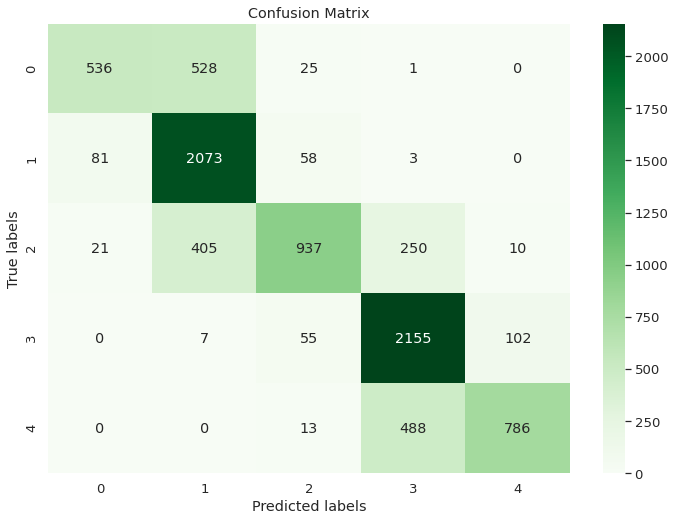

In [19]:
prediction_test(forest_train_y, rfc_predict_train)
plt.savefig('../../N2FL NLP/output/03b_forest_train_accuracy_5class.png')

              precision    recall  f1-score   support

     LABEL_0       0.60      0.29      0.39       279
     LABEL_1       0.60      0.67      0.63       633
     LABEL_2       0.38      0.49      0.43       389
     LABEL_3       0.54      0.67      0.60       510
     LABEL_4       0.76      0.44      0.56       399

    accuracy                           0.55      2210
   macro avg       0.58      0.51      0.52      2210
weighted avg       0.58      0.55      0.54      2210



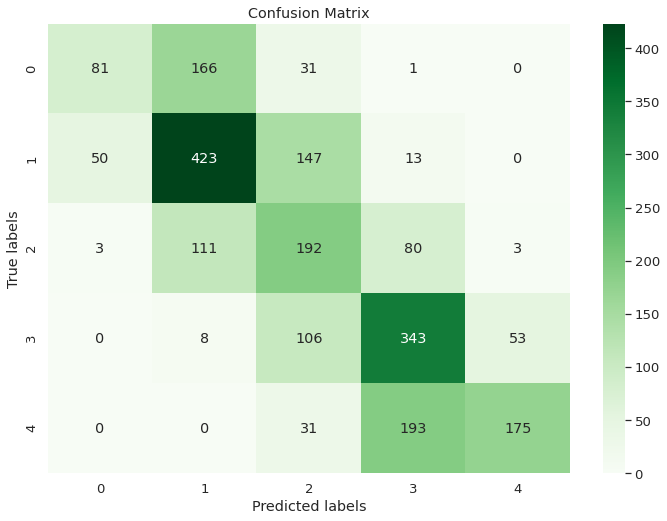

In [20]:
prediction_test(forest_test_y, rfc_predict_test)
plt.savefig('../../N2FL NLP/output/03b_forest_test_accuracy_5class.png')

### Run some quick calculations to see other metrics of accuracy

In [21]:
# test one-off accuracy
test = {"truth": forest_test_y, "prediction": rfc_predict_test}
test = pd.DataFrame(test)

In [22]:
test["truth"] = test["truth"].str.slice(start=6).astype(float)
test["prediction"] = test["prediction"].str.slice(start=6).astype(float)

In [23]:
test.head()

,truth,prediction
0,1.0,1.0
1,0.0,1.0
2,2.0,1.0
3,4.0,4.0
4,0.0,2.0


In [24]:
test["error"] = abs(test["truth"] - test["prediction"])

In [25]:
test["error"][test["error"]<=1].shape[0] / 2210

0.9592760180995475

In [26]:
test2 = test.copy()

In [27]:
test2["truth"][test2["truth"]==1] = 0
test2["truth"][test2["truth"]==3] = 4
test2["prediction"][test2["prediction"]==1] = 0
test2["prediction"][test2["prediction"]==3] = 4

In [28]:
test2["error"] = abs(test2["truth"] - test2["prediction"])

In [29]:
test2["error"][test2["error"]==0].shape[0] / 2210

0.7583710407239819

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82       912
         2.0       0.38      0.49      0.43       389
         4.0       0.89      0.84      0.86       909

    accuracy                           0.76      2210
   macro avg       0.71      0.71      0.70      2210
weighted avg       0.78      0.76      0.77      2210



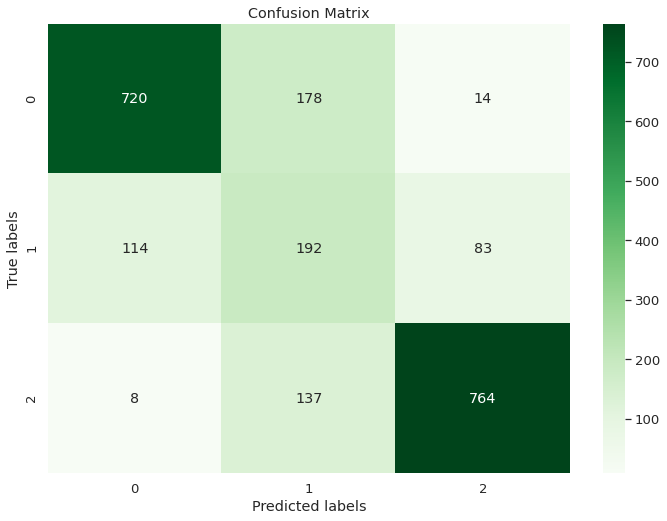

In [30]:
prediction_test(test2["truth"], test2["prediction"])
plt.savefig('../../N2FL NLP/output/03b_forest_test_accuracy_3class.png')

### Output the model for use in next script

In [31]:
pickle.dump(rfc, open("../../N2FL NLP/data/rfc.sav", "wb"))

In [32]:
#testing = pickle.load(open("output/rfc.sav", "rb"))